# Sistema di Face Detection per una fotocamera digitale


## Introduzione

Per sviluppare questo progetto, non essendo stato fornito materiale implementativo durante le lezioni, ho seguito le indicazioni del corso che prevedono una ricerca bibliografica approfondita per identificare le soluzioni più adatte e adattarle alle limitazioni richieste.

La pianificazione delle fasi di lavoro è stata supportata dall’analisi di codici già presenti online (ad esempio su GitHub, Stack Overflow e forum di programmazione) e dall’utilizzo di strumenti di intelligenza artificiale come supporto per organizzare i passaggi, individuare librerie utili e chiarire il funzionamento di funzioni complesse.

Le principali librerie utilizzate sono:

- OpenCV: per l’elaborazione delle immagini, tra cui caricamento, conversione in scala di grigi, rilevamento e disegno di bounding box.
- scikit-image: per funzionalità avanzate di elaborazione e trasformazione delle immagini, come il calcolo dell’istogramma dei gradienti (HOG).
- Matplotlib: per la visualizzazione grafica dei risultati intermedi e finali.
- NumPy: per la gestione di array e operazioni matematiche ottimizzate.
- scikit-learn: per l’implementazione di modelli di machine learning, suddivisione del dataset, normalizzazione dei dati e valutazione delle performance.
- Joblib: per il salvataggio e il caricamento del modello addestrato.

Per la documentazione tecnica, sono state consultate fonti quali la documentazione ufficiale di OpenCV (https://docs.opencv.org), scikit-learn (https://scikit-learn.org/stable/documentation.html) e articoli divulgativi su siti come Towards Data Science e GeeksforGeeks.



## Caricamento delle librerie

In [ ]:
import os
import zipfile
import shutil
import random
import io
import requests

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import imutils

from skimage.feature import hog
from skimage import io as skio
from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import loguniform

import joblib

from torchvision.datasets import STL10
from google.colab.patches import cv2_imshow
from io import BytesIO


## Costruzione del dataset


Per il progetto è stato necessario creare un dataset personalizzato di immagini di volti e non  volti, poiché non era disponibile un set già pronto conforme alle nostre esigenze.

La creazione del dataset è avvenuta seguendo questi passaggi:

- **Raccolta delle immagini**: le immagini sono state reperite online da datasets disponibili su Kaggle, uno per le immagini contenenti solo volti ed uno per le immagini contenenti "non volti", rispettivamente:

- FaceScrub
- Self-Taught Learning 10 (STL-10)

- **Selezione delle immagini**: per rispettare il vincolo del progetto relativo all'uso limitato delle risorse di calcolo, è stata scelta solo una parte delle immagini disponibili. In questo modo il dataset rimane rappresentativo ma consente di addestrare e testare il modello senza sovraccaricare il sistema.

- **Selezione delle classi**: le immagini sono state organizzate in categorie in base all’obiettivo del progetto, ovvero volti presenti vs. volti assenti.

- **Pre-elaborazione**: ogni immagine è stata ridimensionata a dimensioni uniformi, convertita in scala di grigi e normalizzata per rendere omogeneo il dataset. Questo passaggio facilita il successivo calcolo delle caratteristiche (feature) e riduce il rumore.

- **Suddivisione**: infine, il dataset è stato diviso in set di training e test, mantenendo proporzioni equilibrate tra le classi per evitare bias durante l’addestramento.




### Creazione dataset 'faces' da FaceScrub

In [ ]:
import os
kaggle_creds = {'KAGGLE_USERNAME': 'your_username',
                'KAGGLE_KEY': 'your_api_key'}

os.environ['KAGGLE_USERNAME'] = kaggle_creds['KAGGLE_USERNAME']
os.environ['KAGGLE_KEY'] = kaggle_creds['KAGGLE_KEY']

In [ ]:
!kaggle datasets download -d rajnishe/facescrub-full #trovato cercando tra i datasets disponibili su Kaggle

DATA_FOLDER = '/content/data'
os.makedirs(DATA_FOLDER, exist_ok=True)

ZIP_FILE = '/content/facescrub-full.zip'

with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall(DATA_FOLDER)

Dataset URL: https://www.kaggle.com/datasets/rajnishe/facescrub-full
License(s): GNU Affero General Public License 3.0
 90% 580M/645M [00:03<00:01, 57.6MB/s]
100% 645M/645M [00:03<00:00, 186MB/s] 


Il dataset FaceScrub è organizzato in due cartelle principali: una dedicata agli attori e una alle attrici. All'interno di ciascuna cartella, sono presenti delle sottocartelle corrispondenti a ogni individuo, contenenti le immagini che lo ritraggono. Per utilizzare il dataset, si procede scaricando l'intero file ZIP da Kaggle e estraendo le due cartelle principali, `actor_faces` e `actress_faces`, tramite il modulo `zipfile`.

Per ottimizzare l'uso delle risorse computazionali, è stata effettuata una selezione casuale di immagini: il 12.2% delle immagini degli attori e il 12.2% delle immagini delle attrici è stato mantenuto, riducendo considerevolmente la dimensione totale del dataset.

Inoltre, è stata scelta esclusivamente la selezione di immagini in formato JPEG. Sebbene non sia strettamente necessario, questa scelta permette di avere un dataset omogeneo per quanto riguarda il formato delle immagini, facilitando la gestione e il preprocessing, considerando anche che quasi tutte le immagini del dataset sono già in JPEG.


In [ ]:
ACTOR_FOLDER = '/content/data/actor_faces'
ACTRESS_FOLDER = '/content/data/actress_faces'

TARGET_FOLDER = '/content/faces'
os.makedirs(TARGET_FOLDER, exist_ok=True)


def select_and_move_images(source_folder, target_folder, fraction=0.122, seed=42):
  """
  Seleziona una frazione di immagini JPEG dalla cartella sorgente e le sposta nella cartella di destinazione.

  Parametri:
  - source_folder (str): Percorso della cartella sorgente contenente le immagini.
  - target_folder (str): Percorso della cartella di destinazione dove verranno spostate le immagini selezionate.
  - fraction (float): Frazione di immagini da selezionare e spostare. Il valore predefinito è 0.122.
  - seed (int): Valore iniziale per il generatore di numeri casuali, per garantire la riproducibilità. Il valore predefinito è 42.
"""

    random.seed(seed)

    for root, _, files in os.walk(source_folder):
        jpeg_files = [file for file in files if file.endswith('.jpeg')]
        num_files_to_select = int(len(jpeg_files) * fraction)
        selected_files = random.sample(jpeg_files, num_files_to_select)

        for file in selected_files:
            source_file = os.path.join(root, file)
            target_file = os.path.join(target_folder, file)
            shutil.move(source_file, target_file)


select_and_move_images(ACTOR_FOLDER, TARGET_FOLDER)
select_and_move_images(ACTRESS_FOLDER, TARGET_FOLDER)

num_images_faces = len(os.listdir(TARGET_FOLDER))
print('Number of images with faces:', num_images_faces)

Number of images with faces: 4891


A questo punto si procede a verificare quale sia l'immagine con le dimensioni più piccole e quella con le dimensioni più grandi (in pixel). Inoltre, si verifica anche che tutte le immagini siano a colori (3 canali).

Immagine più piccola: Philip_Seymour_Hoffman_92203_47811.jpeg (103, 103)
Immagine più grande: Dustin_Hoffman_33636_17941.jpeg (1911, 1911)
Tutte RGB


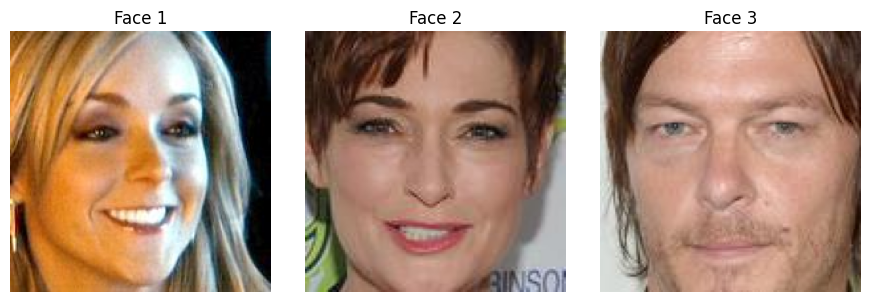

In [ ]:
# Controllo dimensioni e canali
smallest_image = None
largest_image = None
smallest_dimensions = None
largest_dimensions = None
all_color_images = True

for img_name in os.listdir(TARGET_FOLDER):
    img_path = os.path.join(TARGET_FOLDER, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Errore lettura {img_name}")
        continue

    h, w, c = img.shape

    if smallest_dimensions is None or (h*w) < (smallest_dimensions[0] * smallest_dimensions[1]):
        smallest_dimensions = (h, w)
        smallest_image = img_name

    if largest_dimensions is None or (h*w) > (largest_dimensions[0] * largest_dimensions[1]):
        largest_dimensions = (h, w)
        largest_image = img_name

    if c != 3:
        all_color_images = False

print(f"Immagine più piccola: {smallest_image} {smallest_dimensions}")
print(f"Immagine più grande: {largest_image} {largest_dimensions}")
print("Tutte RGB" if all_color_images else "Alcune non RGB")

# Mostra alcune immagini campione
sample_files = random.sample(os.listdir(TARGET_FOLDER), 3)

plt.figure(figsize=(9, 3))
for i, file in enumerate(sample_files):
    img_path = os.path.join(TARGET_FOLDER, file)
    img = plt.imread(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Face {i+1}")

plt.tight_layout()
plt.show()

### Creazione dataset 'no_faces'

In [ ]:
# Scarica dataset STL-10 anche questo trovato su kaggle cercando tra i datasets

!kaggle datasets download -d jessicali9530/stl10


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stl10
License(s): other
 96% 1.81G/1.88G [00:10<00:00, 99.5MB/s]
100% 1.88G/1.88G [00:10<00:00, 187MB/s] 


In questa parte del codice si gestisce l’estrazione e la selezione delle immagini dal dataset STL-10, concentrandosi esclusivamente sulle immagini senza volti.

Per prima cosa, vengono definite:
- la cartella principale dei dati (`DATA_FOLDER`),
- la cartella dedicata al file ZIP del dataset (`ZIP_FILE`),
- e la cartella destinata alle immagini convertite in JPEG (`JPEG_FOLDER`).

Se la cartella JPEG non esiste, viene creata automaticamente.

Successivamente, si apre il file ZIP del dataset e si estraggono solo le immagini PNG presenti nella sottocartella `unlabeled_images`. In questo modo si evitano dati non necessari e ci si concentra esclusivamente sulle immagini “non etichettate”.

Una volta estratte, viene creata la lista di tutti i file PNG disponibili e se ne seleziona casualmente solo una piccola frazione (ad esempio il 4%), per ridurre i tempi di elaborazione e lavorare con un sottoinsieme rappresentativo.

Infine, le immagini selezionate vengono convertite da PNG a JPEG e salvate nella cartella dedicata (`JPEG_FOLDER`). Al termine, il codice stampa il numero totale di immagini senza volti disponibili, pronte per eventuali analisi o elaborazioni successive.



In [ ]:
DATA_FOLDER = '/content/data'
ZIP_FILE = '/content/stl10.zip'
JPEG_FOLDER = '/content/no_faces'
os.makedirs(JPEG_FOLDER, exist_ok=True)

# Estrazione solo delle immagini PNG
with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if member.startswith('unlabeled_images/') and not member.endswith('/'):
            zip_ref.extract(member, DATA_FOLDER)

# Cartella con immagini estratte
PNG_FOLDER = os.path.join(DATA_FOLDER, 'unlabeled_images')
png_files = [f for f in os.listdir(PNG_FOLDER) if f.endswith('.png')]

# Selezione di una frazione (4%)
fraction = 0.04
random.seed(42)
selected_files = random.sample(png_files, int(len(png_files) * fraction))

# Conversione PNG -> JPEG solo delle immagini selezionate
for png_file in selected_files:
    png_path = os.path.join(PNG_FOLDER, png_file)
    img = cv2.imread(png_path)
    jpeg_path = os.path.join(JPEG_FOLDER, os.path.splitext(png_file)[0] + '.jpeg')
    cv2.imwrite(jpeg_path, img)

num_images_no_faces = len(os.listdir(JPEG_FOLDER))
print('Number of images without faces:', num_images_no_faces)


Number of images without faces: 4000


Dopodichè si analizzano tutte le immagini presenti nella cartella delle immagini senza volti (TARGET_NEG_FOLDER). Per ogni immagine, il codice apre il file e ne legge le dimensioni e il tipo di colore.

Viene poi identificata l’immagine più piccola e quella più grande in termini di pixel totali, memorizzandone anche il nome. Inoltre, il codice verifica se tutte le immagini sono a colori (RGB) o se alcune sono in scala di grigi.

Al termine, vengono stampati il nome e le dimensioni dell’immagine più piccola e di quella più grande, insieme a un messaggio che indica se tutte le immagini sono RGB.

In [ ]:
TARGET_NEG_FOLDER = '/content/no_faces'
smallest_image = None
largest_image = None
smallest_dimensions = None
largest_dimensions = None
all_color_images = True

for img_name in os.listdir(TARGET_NEG_FOLDER):
    img_path = os.path.join(TARGET_NEG_FOLDER, img_name)
    with Image.open(img_path) as img:
        w, h = img.size
        mode = img.mode

        if smallest_dimensions is None or (w * h) < (smallest_dimensions[0] * smallest_dimensions[1]):
            smallest_dimensions = (w, h)
            smallest_image = img_name

        if largest_dimensions is None or (w * h) > (largest_dimensions[0] * largest_dimensions[1]):
            largest_dimensions = (w, h)
            largest_image = img_name

        if mode != 'RGB':
            all_color_images = False

print(f"Immagine più piccola: {smallest_image} with size {smallest_dimensions}")
print(f"Immagine più grande: {largest_image} with size {largest_dimensions}")
print("Tutte RGB" if all_color_images else "qualcuno non RGB")


Immagine più piccola: unlabeled_image_png_16939.jpeg with size (96, 96)
Immagine più grande: unlabeled_image_png_16939.jpeg with size (96, 96)
Tutte RGB


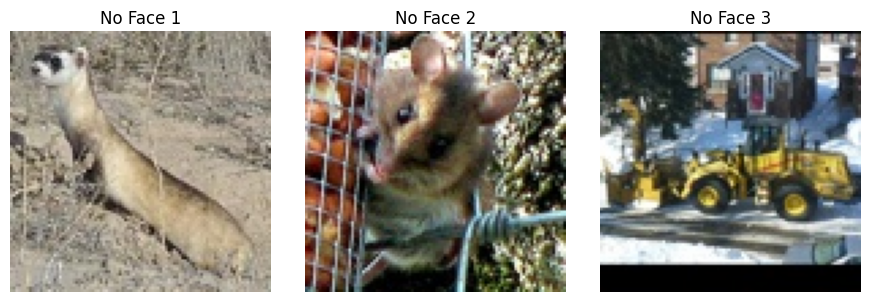

In [ ]:
# Mostra 3 immagini casuali dalla cartella no_faces
sample_files = random.sample(os.listdir(TARGET_NEG_FOLDER), 3)

plt.figure(figsize=(9, 3))
for i, file in enumerate(sample_files):
    img_path = os.path.join(TARGET_NEG_FOLDER, file)
    img = plt.imread(img_path)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"No Face {i+1}")

plt.tight_layout()
plt.show()

## Preprocessing

In questa fase tutte le immagini vengono preprocessate prima di essere utilizzate per
l'addestramento del modello. Le operazioni principali includono:

1. Conversione in scala di grigi (bianco e nero):
   - Ridurre le immagini a un singolo canale (grigio) semplifica i dati e diminuisce
     la complessità computazionale, poiché il modello non deve elaborare informazioni
     sui colori.
   - Questa scelta è comune in letteratura quando il colore non è essenziale per la
     classificazione dei volti o per altre attività di riconoscimento di pattern.
     (Fonte di riferimento: tutorial OpenCV e libri di computer vision, ad esempio
     “Learning OpenCV” di Gary Bradski e Adrian Kaehler)

2. Ridimensionamento a 64x64 pixel:
   - Uniformare la dimensione delle immagini permette di creare un dataset coerente,
     evitando problemi dovuti a immagini di dimensioni diverse.
   - Lavorare con immagini più piccole riduce il tempo di elaborazione e l’uso di
     memoria, ottimizzando il progetto per sistemi con capacità di calcolo limitate.

In sintesi, questo preprocessing garantisce un dataset omogeneo, meno pesante e pronto per essere utilizzato nelle fasi successive del progetto, riducendo sia i tempi di calcolo sia le risorse necessarie.



In [ ]:
# Cartella con volti già estratti
FACES_FOLDER = "faces"

# Lista per memorizzare le immagini preprocessate
faces = []

for file_name in os.listdir(FACES_FOLDER):
    img_path = os.path.join(FACES_FOLDER, file_name)

    # Legge immagine
    img = cv2.imread(img_path)

    if img is None:
        continue  # salta se il file non è valido

    # Ridimensionamento a 64x64
    img_resized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

    # Conversione in scala di grigi
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Aggiungi alla lista
    faces.append(img_gray)

faces = np.array(faces)

print(f"Preprocessing completato: {len(faces)} immagini di volti pronte.")

Preprocessing completato: 4891 immagini di volti pronte.


array([[ 35,  33,  31, ...,  79,  78,  76],
       [ 32,  32,  30, ...,  79,  78,  76],
       [ 32,  33,  31, ...,  80,  75,  77],
       ...,
       [107, 109, 109, ...,  84,  83,  82],
       [109, 107, 109, ...,  84,  83,  82],
       [111, 105, 105, ...,  86,  84,  83]], dtype=uint8)
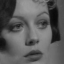

In [ ]:
faces[0]

Uguale per la carella no_faces:

In [ ]:
# Cartella con immagini senza volti
NO_FACES_FOLDER = "no_faces"

# Lista per memorizzare le immagini preprocessate senza volti
no_faces = []

for file_name in os.listdir(NO_FACES_FOLDER):
    img_path = os.path.join(NO_FACES_FOLDER, file_name)

    # Legge immagine
    img = cv2.imread(img_path)

    if img is None:
        continue  # salta se il file non è valido

    # Ridimensionamento a 64x64
    img_resized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

    # Conversione in scala di grigi
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Aggiungi alla lista
    no_faces.append(img_gray)

no_faces = np.array(no_faces)

print(f"Preprocessing completato: {len(no_faces)} immagini senza volti pronte.")

Preprocessing completato: 4000 immagini senza volti pronte.


array([[129, 129, 128, ..., 137, 126, 118],
       [132, 124, 124, ..., 140, 129, 123],
       [141, 131, 121, ..., 145, 137, 141],
       ...,
       [164, 158, 162, ..., 159, 163, 157],
       [130, 132, 128, ..., 131, 131, 132],
       [109, 111, 109, ..., 113, 113, 113]], dtype=uint8)
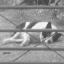

In [ ]:
no_faces[0]

Si crea un array NumPy per le immagini di volti (faces_array) e per quelle senza volti (no_faces_array) e si stampano i rispettivi numeri. Poi si concatenano lungo la prima dimensione per ottenere X, l’array unificato di tutte le immagini. Vengono definiti gli indici della prima e ultima immagine di volti e non volti, e queste quattro immagini vengono visualizzate in una griglia 2x2 con titoli e senza assi.

Numero immagini volti: 4891
Numero immagini non volti: 4000
Shape array unito X: (8891, 64, 64)


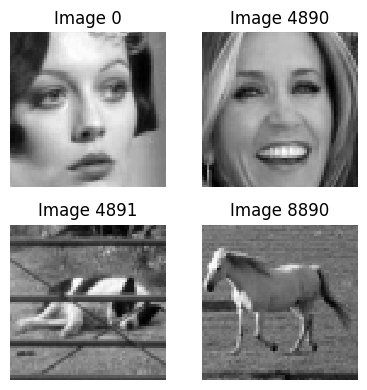

In [ ]:
# Convertiamo le liste in array numpy (dimensione: N x 64 x 64)
faces_array = np.array(faces)
no_faces_array = np.array(no_faces)

print(f"Numero immagini volti: {faces_array.shape[0]}")
print(f"Numero immagini non volti: {no_faces_array.shape[0]}")

# Concatenazione lungo la prima dimensione (numero immagini)
X = np.concatenate((faces_array, no_faces_array), axis=0)

print(f"Shape array unito X: {X.shape}")

# Indici da visualizzare:
# Prima e ultima immagine di volti
first_face_idx = 0
last_face_idx = faces_array.shape[0] - 1

# Prima e ultima immagine di non volti
first_no_face_idx = faces_array.shape[0]
last_no_face_idx = X.shape[0] - 1

INDEXES = [first_face_idx, last_face_idx, first_no_face_idx, last_no_face_idx]

fig, axs = plt.subplots(2, 2, figsize=(4, 4))  # figura più piccola
for i, idx in enumerate(INDEXES):
    row = i // 2
    col = i % 2
    axs[row, col].imshow(X[idx], cmap='gray', interpolation='nearest')
    axs[row, col].set_title(f'Image {idx}')
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

Si crea l’array y delle etichette: tutti 1 per le immagini di volti e 0 per quelle senza volti, in modo da allinearle all’array X delle immagini. Si stampa la forma dell’array e alcune informazioni di controllo: le prime 5 etichette, l’ultima immagine con volto, la prima immagine senza volto e le ultime 5 etichette.

In [ ]:
y = np.array([1]*faces.shape[0] + [0]*no_faces.shape[0])

print(y.shape)

print('\nFirst 5 labels:', y[:5])
# L'ultimo indice delle immagini "con volti" sarà 4890 (4891 - 1)
print('Last image with a face: label', y[4890])
# Il primo indice delle immagini "senza volti" sarà 4891
print('First image without a face: label', y[4891])
print('Last 5 labels:', y[-5:])

(8891,)

First 5 labels: [1 1 1 1 1]
Last image with a face: label 1
First image without a face: label 0
Last 5 labels: [0 0 0 0 0]


Di seguito viene applicato l’algoritmo HOG alla prima immagine del dataset.
Per ottenere il feature descriptor `fd` e l’immagine trasformata `hog_image` viene utilizzata la funzione `hog`, specificando i seguenti argomenti:

- image=image: prima immagine dell’array X (cioè image=X[0]).
- orientations=9: numero di orientamenti del gradiente; valori comuni sono tra 6 e 12, e in questo caso si sceglie 9.
  Un numero maggiore di orientamenti aumenta la capacità del descrittore di catturare dettagli, ma incrementa anche la dimensione del vettore delle caratteristiche.
- pixels_per_cell=(8, 8): dimensioni in pixel di ciascuna cella. Celle più piccole catturano più dettagli locali, mentre celle più grandi riducono la dimensione del vettore ma possono perdere dettagli fini.
  Valori tipici sono (8,8) o (16,16).
- cells_per_block=(2, 2): numero di celle in ogni blocco. I blocchi aiutano a normalizzare le caratteristiche su diverse regioni dell’immagine, migliorando la robustezza rispetto alle variazioni di illuminazione.
- visualize=True: restituisce anche l’immagine dei gradienti orientati.

Dopo l’esecuzione, vengono mostrate a schermo le dimensioni del feature descriptor, i primi cinque elementi di fd e vengono plottate le immagini originale e trasformata dall’algoritmo HOG.


Feature Descriptor dimensions: (1764,)
First 5 elements of fd array: [0.30740924 0.17713961 0.01738904 0.07709043 0.07386037]



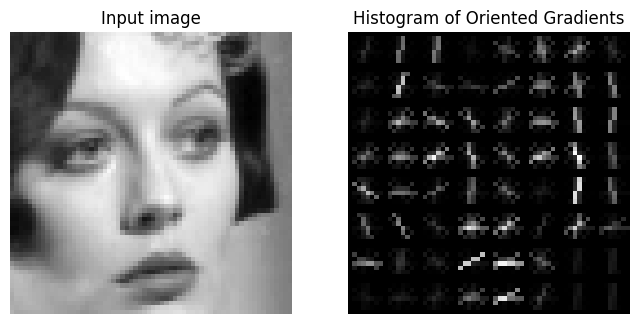

In [ ]:
image=X[0]

fd, hog_image = hog(image=image,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=True)

print('Feature Descriptor dimensions:', fd.shape)
print('First 5 elements of fd array:', fd[:5])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

print('')

plt.show()

Dunque, dopo aver descritto e applicato il descrittore HOG sulla prima immagine si procede ad estrarre le hog features da tutte le immagini presenti nell'array X salvandole nell'array hog_features_X. Per estrarre tali features viene costruita la funzione get_hog_features.



In [ ]:
def get_hog_features(image,
                     orientations=9,
                     pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2)):

    """
    Extract Histogram of Oriented Gradients (HOG) features from a 2D grayscale
    image.

    Parameters:
    image (ndarray): 2D grayscale image.
    orientations (int): Number of orientation bins. Default is 9.
    pixels_per_cell (tuple): Size (in pixels) of a cell. Default is (8, 8).
    cells_per_block (tuple): Number of cells in each block. Default is (2, 2).

    Returns:
    ndarray: HOG feature vector.

    Raises:
    ValueError: If the input image is not a 2D grayscale image.
    """

    if len(image.shape) != 2:
        raise ValueError("Input image must be a 2D grayscale image")

    return hog(image,
               orientations,
               pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block,
               feature_vector=True)

In [ ]:
hog_features_list = []

for image in X:
    fd = get_hog_features(image)
    hog_features_list.append(fd)

hog_features_X = np.array(hog_features_list)

print('HOG Features array dimensions:', hog_features_X.shape)
print('HOG Features min value:', hog_features_X.min())
print('HOG Features max value:', hog_features_X.max())

HOG Features array dimensions: (8891, 1764)
HOG Features min value: 0.0
HOG Features max value: 0.9999999987499999


L'array delle HOG features è costituito da 1764 valori compresi tra 0 ed 1 per ciascuna delle 8891 immagini (i valori sono dunque normalizzati e pronti per essere utilizzati dal classificatore).

## Modellizzazione del classificatore con HOG Features
Arrivati a questo punto è possibile utilizzare le hog features estratte per costruire il set di addestramento e di test (Hold-out) su cui verrà addestrato e valutato il classificatore (SVM) tramite la funzione train_test_split. L'80 % del dataset andrà a costituire il Train Set e il 20% il Test Set.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(hog_features_X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print('Train Set dimensions:', X_train.shape, y_train.shape)
print('Test Set dimensions:', X_test.shape, y_test.shape)

Train Set dimensions: (7112, 1764) (7112,)
Test Set dimensions: (1779, 1764) (1779,)


Si procede quindi a effettuare una Grid Search per individuare il kernel del Support Vector Classifier (SVC) che massimizza l'accuracy. I passaggi principali sono i seguenti:

Dopo aver completato la Grid Search, viene selezionato il miglior modello tramite il metodo `best_estimator_`. Successivamente, il modello viene addestrato sull'intero Train Set e valutato sul Test Set, contenente immagini mai viste dal modello durante la Grid Search.

Per la valutazione delle prestazioni del modello:
- Si effettuano le predizioni sul Test Set tramite il metodo `predict` del classificatore.
- Si ricava il Classification Report, contenente accuracy e altre metriche d'interesse.
- Si genera la Confusion Matrix per analizzare quali e quanti errori il modello commette. (Si utilizzano rispettivamente le funzioni `classification_report` e `confusion_matrix` di scikit-learn.)

Allo stesso modo, vengono calcolati il classification report e la confusion matrix anche per il Train Set, in modo da valutare un eventuale overfitting del modello.




In [ ]:
svc = SVC(probability=True, random_state=42)

param_grid_svc = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_svc = GridSearchCV(estimator=svc,
                      param_grid=param_grid_svc,
                      scoring='accuracy',
                      cv=kf,
                      n_jobs=-1)

gs_svc.fit(X_train, y_train)

print(f'Best params SVC: {gs_svc.best_params_}')
print(f'Best Mean Validation Accuracy SVC {gs_svc.best_score_:.4f}')

svc = gs_svc.best_estimator_
svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)

print('\nTrain Set - Classification Report:')
print(classification_report(y_train, y_pred_train, digits=4))

print('\nTrain Set - Confusion Matrix:')
print(confusion_matrix(y_train, y_pred_train))

print('\nTest Set - Classification Report:')
print(classification_report(y_test, y_pred_test, digits=4))

print('\nTest Set - Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_test))

Best params SVC: {'kernel': 'poly'}
Best Mean Validation Accuracy SVC 0.9982

Train Set - Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3194
           1     1.0000    1.0000    1.0000      3918

    accuracy                         1.0000      7112
   macro avg     1.0000    1.0000    1.0000      7112
weighted avg     1.0000    1.0000    1.0000      7112


Train Set - Confusion Matrix:
[[3194    0]
 [   0 3918]]

Test Set - Classification Report:
              precision    recall  f1-score   support

           0     0.9963    0.9988    0.9975       806
           1     0.9990    0.9969    0.9979       973

    accuracy                         0.9978      1779
   macro avg     0.9976    0.9978    0.9977      1779
weighted avg     0.9978    0.9978    0.9978      1779


Test Set - Confusion Matrix:
[[805   1]
 [  3 970]]


Dai risultati ottenuti vediamo che il classificatore SVC con kernel polinomiale ha performato molto bene. Sul training set, tutte le immagini sono state classificate correttamente, come mostrano la matrice di confusione e le metriche di precision, recall e f1-score pari a 1.0.

Anche sul test set il modello generalizza perfettamente, con un’accuratezza complessiva dello 0.9978 e pochissimi errori: solo 1 falso positivo e 3 falsi negativi su 1779 immagini. Questo indica che il modello riesce a distinguere con precisione quasi assoluta le immagini contenenti volti da quelle senza volti, confermando l’efficacia dell’approccio basato sulle feature HOG e sul SVC con kernel polinomiale.

Verificate le ottime prestazioni del SVC con le HOG features è possibile salvare tale modello addestrato utilizzando la libreria joblib e in particolare la sua funzione dump.

In [ ]:
joblib.dump(svc, 'face_classifier.joblib')

['face_classifier.joblib']

## Face detection

Dopo aver completato la fase di classificazione dei volti, si può passare alla rilevazione dei volti (Face Detection), con l’obiettivo di individuare e segnare con un riquadro (bounding box) i volti presenti.

- Caricamento immagine dall’URL (load_image_from_url)
  - Scarica l’immagine dal web e la converte in array numpy compatibile con OpenCV.
  - Restituisce immagine a colori e in scala di grigi.

- Creazione della piramide di immagini (pyramid)
  - Genera versioni ridotte dell’immagine originale per rilevare volti di dimensioni diverse.

- Sliding window (sliding_window)
  - Scorre una finestra sull’immagine e estrae patch da analizzare.

- Rilevazione volti (find_faces)
  - Usa SVM pre-addestrato e feature HOG per identificare volti.
  - Salva le coordinate e le probabilità dei volti rilevati.

- Disegno dei bounding box (draw_bboxes)
  - Disegna rettangoli attorno ai volti e mostra la probabilità di rilevazione.
  - Visualizza l’immagine finale su Colab.

- Flusso completo
  - Carico immagine → Creo piramide → Sliding window → HOG → Predizione SVM → Disegno rettangoli → Mostro immagine.

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_image_from_url(url):
    """
    Carica un'immagine da un URL e restituisce sia l'immagine originale a colori
    sia la versione in scala di grigi.

    Parametri:
    url (str): URL dell'immagine da scaricare.

    Ritorna:
    tuple: (original_image, gray_image)
        original_image: immagine originale a colori (BGR)
        gray_image: immagine in scala di grigi
    """
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Converti in array numpy
    image = np.array(image)

    # Se ha 4 canali (RGBA), converte in BGR
    if image.shape[-1] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)

    # Immagine in scala di grigi
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy()

    return image, gray_image


array([[[218, 220, 217],
        [221, 223, 220],
        [221, 223, 220],
        ...,
        [133,  64,  35],
        [127,  51,  25],
        [124,  44,  17]],

       [[226, 228, 227],
        [228, 233, 229],
        [231, 233, 232],
        ...,
        [123,  54,  25],
        [132,  55,  27],
        [134,  55,  25]],

       [[227, 231, 232],
        [231, 237, 235],
        [233, 237, 238],
        ...,
        [130,  59,  27],
        [150,  71,  40],
        [156,  75,  45]],

       ...,

       [[ 10,  28,  32],
        [ 10,  28,  32],
        [ 10,  28,  32],
        ...,
        [ 52,  69,  76],
        [ 52,  69,  76],
        [ 52,  69,  76]],

       [[ 14,  32,  36],
        [ 14,  32,  36],
        [ 14,  32,  36],
        ...,
        [ 45,  64,  70],
        [ 45,  64,  70],
        [ 45,  64,  70]],

       [[ 13,  31,  35],
        [ 14,  32,  36],
        [ 14,  32,  36],
        ...,
        [ 42,  61,  67],
        [ 42,  61,  67],
        [ 42,  61,  67]]], dtype=uint8)
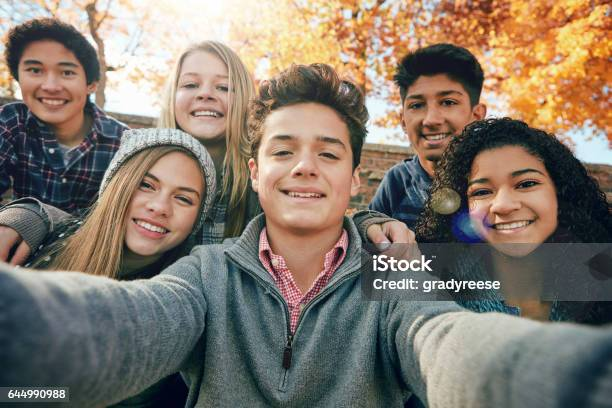

In [ ]:
url='https://media.istockphoto.com/id/644990988/it/foto/ma-in-primo-luogo-cerchiamo-un-selfie.jpg?s=612x612&w=is&k=20&c=e5sTIkLkWO-aBb3u4Bixpv2jMAZ_HQunw0R2fzF7Ymg='
image, image_gray = load_image_from_url(url)
image

array([[219, 222, 222, ...,  63,  52,  45],
       [227, 231, 232, ...,  53,  55,  55],
       [231, 236, 237, ...,  58,  71,  75],
       ...,
       [ 27,  27,  27, ...,  69,  69,  69],
       [ 31,  31,  31, ...,  64,  64,  64],
       [ 30,  31,  31, ...,  61,  61,  61]], dtype=uint8)
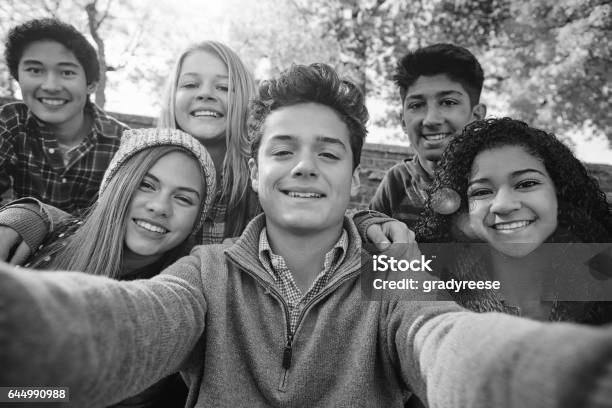

In [ ]:
image_gray

In [ ]:
def pyramid(image, scale, minSize):
    """
    Genera una piramide di immagini riducendo progressivamente l'immagine originale.

    Parametri:
    image (ndarray): Immagine di input.
    scale (float): Fattore di scala.
    minSize (tuple): Dimensione minima dell'immagine.

    Restituisce:
    ndarray: Immagini ridimensionate.
    """
    yield image

    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image


def sliding_window(image, stepSize, windowSize):
    """
    Scorre una finestra sull'immagine restituendo posizione e contenuto della finestra.

    Parametri:
    image (ndarray): Immagine di input.
    stepSize (int): Passo in pixel.
    windowSize (tuple): Dimensione della finestra di scorrimento.

    Restituisce:
    tuple: (x, y, window) dove x e y sono le coordinate in alto a sinistra
           e window è la porzione di immagine.
    """
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


In [ ]:
def find_faces(original_image, gray_image):
    """
    Rileva volti in un'immagine utilizzando un classificatore SVM pre-addestrato e
    caratteristiche HOG.

    Parametri:
    original_image (ndarray): Immagine originale.
    gray_image (ndarray): Versione in scala di grigi dell'immagine originale.

    Restituisce:
    tuple: (detected_faces, probabilities) dove detected_faces è una lista di
           rettangoli di delimitazione dei volti e probabilities è una lista di
           punteggi di confidenza per ogni volto rilevato.
    """

    scale = 1.3
    minSize = (30, 30)
    stepSize = 16
    (winW, winH) = (64, 64)

    svc = joblib.load('face_classifier.joblib')

    detected_faces = []
    probabilities = []

    for resized in pyramid(gray_image, scale=scale, minSize=minSize):
        ratio = gray_image.shape[1] / float(resized.shape[1])
        for (x, y, window) in sliding_window(resized, stepSize=stepSize, windowSize=(winW, winH)):
            if window.shape[0] != winH or window.shape[1] != winW:
                continue

            fd = get_hog_features(window)
            fd = fd.reshape(1, -1)

            pred = svc.predict(fd)
            proba = svc.predict_proba(fd)

            if pred == 1 and proba[0, 1] > 0.85:
                detected_faces.append((int(x * ratio), int(y * ratio), int((x + winW) * ratio), int((y + winH) * ratio)))
                probabilities.append(proba[0, 1])

    return detected_faces, probabilities

La funzione draw_bboxes serve a visualizzare i volti rilevati sull’immagine originale e a mostrare la confidenza della rilevazione.

Passaggi principali:

Scorrere tutte le facce rilevate: la funzione riceve una lista di rettangoli detected_faces e una lista corrispondente di probabilità probabilities.

Disegnare il rettangolo: per ogni faccia, usa le coordinate (x1, y1, x2, y2) per tracciare un rettangolo sull’immagine originale.

Aggiungere la probabilità: sopra ogni rettangolo viene scritto il valore della confidenza (tra 0 e 1) che indica quanto il modello è sicuro che lì ci sia un volto.

Visualizzare l’immagine: su Colab si usa cv2_imshow per mostrare immediatamente l’immagine con i volti evidenziati e le probabilità.

In pratica, questa funzione trasforma i dati numerici della rilevazione in una rappresentazione visiva chiara e immediata, utile per capire se il modello sta funzionando correttamente.

In [ ]:
def draw_bboxes(image_rgb,
                detected_faces,
                probabilities,
                color=(0, 255, 0),
                thickness=2,
                min_proba=0.8):
    """
    Disegna rettangoli intorno ai volti rilevati sull'immagine RGB e annota con
    le probabilità, filtrando quelli sotto una soglia minima.

    Parametri:
    image_rgb (ndarray): Immagine RGB su cui disegnare.
    detected_faces (list): Lista dei rettangoli dei volti rilevati.
    probabilities (list): Lista delle probabilità associate a ciascun volto.
    color (tuple): Colore del rettangolo in formato RGB. Default è verde.
    thickness (int): Spessore dei bordi del rettangolo. Default è 2.
    min_proba (float): Probabilità minima per visualizzare il rettangolo. Default è 0.8.
    """

    # Copia e converti in BGR per OpenCV
    image_bgr = cv2.cvtColor(image_rgb.copy(), cv2.COLOR_RGB2BGR)
    color_bgr = (color[2], color[1], color[0])  # RGB -> BGR

    for ((x1, y1, x2, y2), proba) in zip(detected_faces, probabilities):
        if proba >= min_proba:
            cv2.rectangle(image_bgr, (x1, y1), (x2, y2), color_bgr, thickness)
            cv2.putText(image_bgr,
                        '{:.2f}'.format(proba),
                        (x1, y1 + 20),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        color_bgr,
                        thickness)

    # Visualizza con cv2_imshow (BGR)
    cv2_imshow(image_bgr)


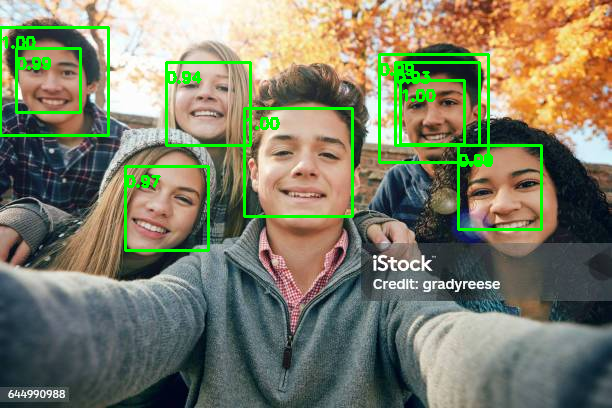

In [ ]:
image, gray_image = load_image_from_url(url)
detected_faces, probabilities = find_faces(original_image, gray_image)
draw_bboxes(original_image, detected_faces, probabilities)


Tutti i volti vengono individuati dai bounding boxes con le relative probabilità, tuttavia, non si ha un risultato soddisfacente poichè diversi di essi hanno più bounding boxes sovrapposti. Una soluzione a questo problema può essere ottenuta tramite la Non Maximum Suppression. Per risolvere il problema dei riquadri sovrapposti su un singolo volto è possibile utilizzare la tecnica: Non Maximum Suppression (NMS). Per studiare il funzionamento teorico di questa tecnica e la sua implementazione tramite OpenCV si prende in considerazione il blog pyimagesearch:
https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

Viene creata la funzione non_max_suppression, che opera seguendo i passaggi principali:

Input:
- detected_faces: elenco di bounding boxes per i volti rilevati, ognuna definita da quattro coordinate (x1, y1, x2, y2).
- probabilities: elenco di probabilità che indichino quanto è probabile che ciascuna bounding box contenga un volto.
- overlapThresh: soglia di sovrapposizione (default 0.3), usata per determinare quando due bounding boxes si considerano troppo simili e una delle due deve essere soppressa.

Ordinamento delle bounding boxes:
- Le bounding boxes vengono ordinate in base alle probabilità in ordine decrescente.
- Questo permette di trattare per prime le rilevazioni con maggiore confidenza.

Iterazione e soppressione:
- Si considera una bounding box alla volta, seguendo l’ordine decrescente di probabilità.
- Si calcola l’area di intersezione tra la bounding box corrente e tutte le altre rimanenti.
- Si determina il rapporto di sovrapposizione tra l’area di intersezione e l’area della bounding box corrente.
- Le bounding boxes con un rapporto di sovrapposizione superiore alla soglia definita vengono rimosse.

Output:
- L’algoritmo restituisce un elenco di bounding boxes selezionate dopo la soppressione delle sovrapposizioni, rappresentando le rilevazioni più accurate e distinte dei volti nell’immagine, insieme alle rispettive probabilità.


In [ ]:
def non_max_suppression(detected_faces, probabilities, overlapThresh=0.3):
    """
    Esegue la soppressione dei rettangoli sovrapposti per rimuovere box ridondanti.

    Parametri:
    detected_faces (list): Lista di rettangoli dei volti rilevati, ognuno definito da
                           quattro coordinate (x1, y1, x2, y2).
    probabilities (list): Lista dei punteggi di confidenza per ogni volto rilevato.
    overlapThresh (float): Soglia di sovrapposizione oltre la quale un box viene eliminato. Default: 0.3.

    Restituisce:
    tuple: (kept_detected_faces, kept_probabilities)
           kept_detected_faces -> lista di rettangoli mantenuti dopo la soppressione
           kept_probabilities -> lista dei punteggi di confidenza corrispondenti
    """

    if len(detected_faces) == 0:
        return [], []

    boxes = np.array(detected_faces)
    probs = np.array(probabilities)
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)[::-1]  # ordina in base alla probabilità decrescente

    while len(idxs) > 0:
        i = idxs[0]  # box con probabilità più alta
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[1:]]

        idxs = np.delete(idxs,
                         np.concatenate(
                             ([0], np.where(overlap > overlapThresh)[0] + 1)))

    kept_detected_faces = boxes[pick].tolist()
    kept_probabilities = probs[pick].tolist()

    return kept_detected_faces, kept_probabilities


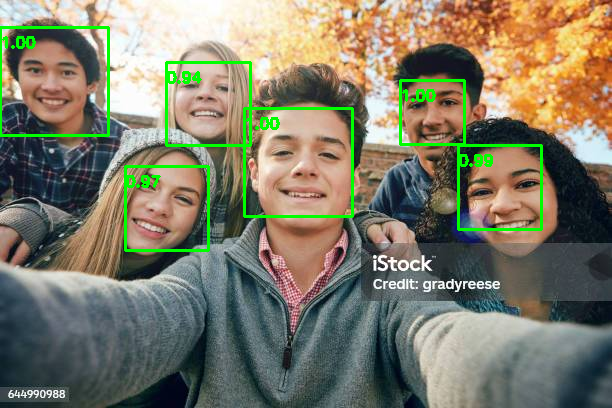

In [ ]:
image, gray_image = load_image_from_url(url)
detected_faces, probabilities = find_faces(image, gray_image)
kept_detected_faces, kept_probabilities = non_max_suppression(detected_faces,
                                                              probabilities)
draw_bboxes(image, kept_detected_faces, kept_probabilities)

A questo punto è possibile testare il sistema di identificazione dei volti utilizzando diverse immagini scaricate da Google.

Per semplificare l’operazione, è utile creare la funzione face_detection, che racchiude tutte le operazioni necessarie per il riconoscimento dei volti. Questa funzione avrà come unico input l’URL dell’immagine da analizzare.

In [ ]:
def face_detection(url):

    """
    Perform face detection on an image and display the result.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    None
        Displays the original image with bounding boxes drawn around detected
        faces.
    """

    image, gray_image = load_image_from_url(url)
    detected_faces, probabilities = find_faces(image, gray_image)
    kept_detected_faces, kept_probabilities = non_max_suppression(detected_faces,
                                                                  probabilities)
    draw_bboxes(image, kept_detected_faces, kept_probabilities)

In [ ]:
url='https://deadline.com/wp-content/uploads/2025/07/RIVL0271_47a920.jpg?w=681&h=383&crop=1'

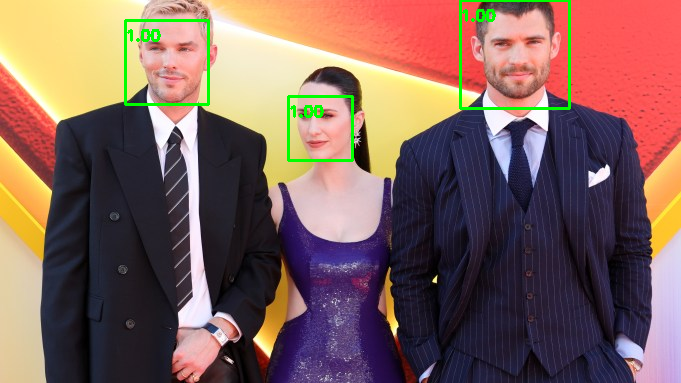

In [ ]:
face_detection(url)

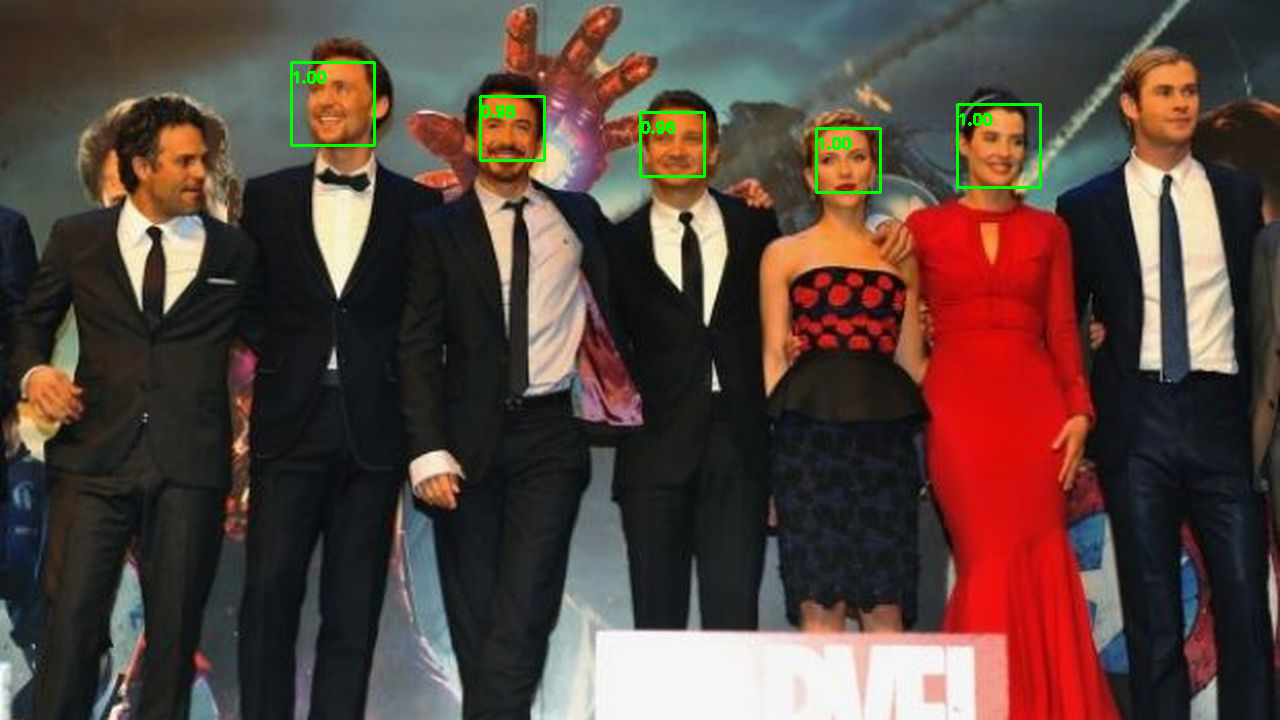

In [ ]:
url='https://cdn.blogo.it/ayUe7IVDT8sE98kmpDExo8nUjKk=/1280x720/smart/https://www.blogo.it/app/uploads/sites/3/2012/04/p37037-620x350-1.jpg'
face_detection(url)

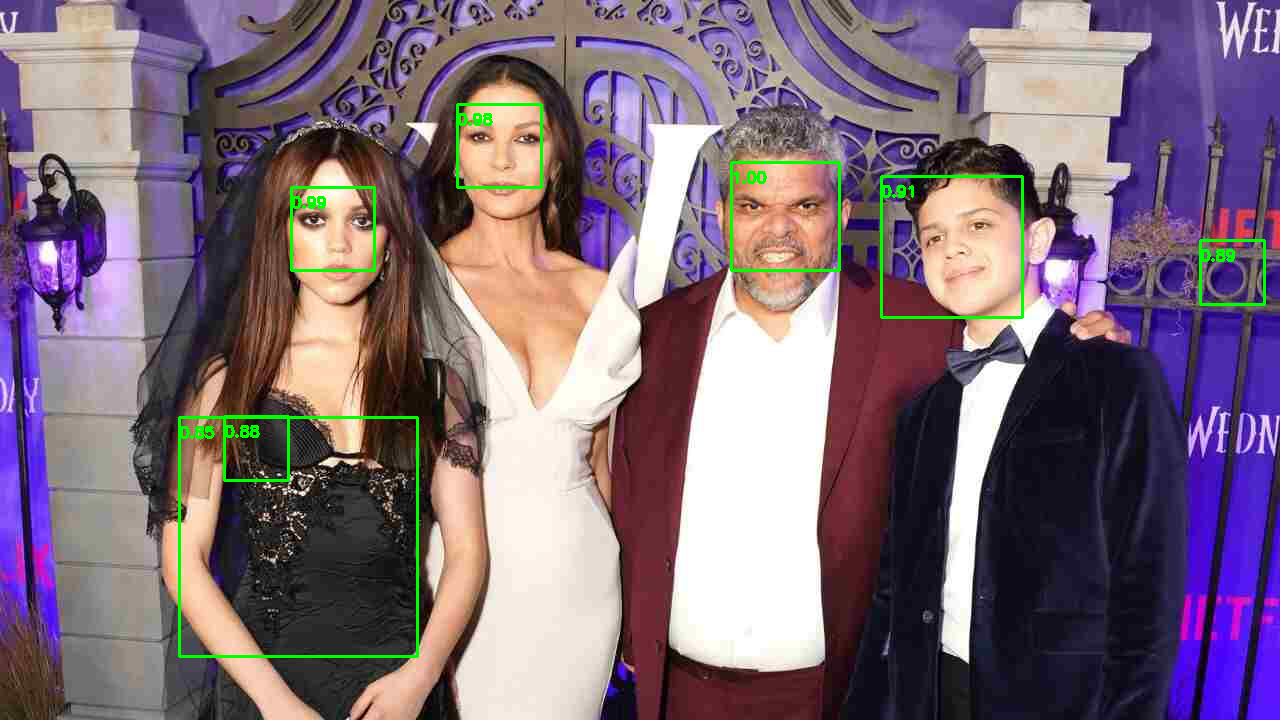

In [ ]:
url='https://www.velvetmag.it/wp-content/uploads/2022/11/mercoledi-velvetmag.jpg'
face_detection(url)

In conclusione, dato l’obiettivo di sviluppare un modello leggero e poco esigente in termini di risorse computazionali, i risultati ottenuti dal sistema di rilevamento volti risultano soddisfacenti (spero!).

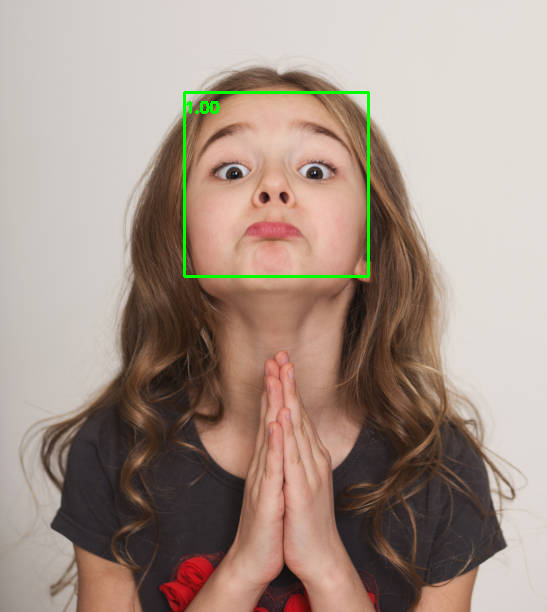

In [ ]:
url='https://media.istockphoto.com/id/1139917088/photo/little-girl-pleading-with-hands-clasped-together.jpg?s=612x612&w=0&k=20&c=MquSFNiUApMnVS7It4mLr4KjDQvQYhhpYQ3vRyHEvT4='
face_detection(url)